In [1]:
!pip install roboschool

In [0]:
import math
import random

import numpy as np
from multiprocessing import Process, Pipe
import os

import gym
import roboschool

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Set up CUDA

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Creating a vector of environments for MultiProcessing


Code obtained from OpenAI baselines :
https://github.com/openai/baselines/tree/master/baselines/common/vec_env

In [0]:
def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    
class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

        
class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs

### Creating some simulation Environments

In [6]:
num_envs = 16
env_name = "RoboschoolWalker2d-v1"

def make_env():
    def _env_maker():
        env = gym.make(env_name)
        return env

    return _env_maker

envs = [make_env() for i in range(num_envs)]

envs = SubprocVecEnv(envs)

env = gym.make(env_name)

num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

print("Number of inputs = ", num_inputs)
print("num_outputs = ", num_outputs)
print("class_name: {} \naction_space: {} \nobservation_space: {} \nreward_range {}".format(env.class_name,
                                                                                       env.action_space, 
                                                                                       env.observation_space, 
                                                                                       env.reward_range))

Number of inputs =  22
num_outputs =  6
class_name: <bound method Wrapper.class_name of <class 'gym.wrappers.time_limit.TimeLimit'>> 
action_space: Box(6,) 
observation_space: Box(22,) 
reward_range (-inf, inf)


### Actor Critic Network


In [0]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs=22, num_outputs=6, hidden_size=(128,64), std=0.0):
        super(ActorCritic, self).__init__()
        
        # critic -> value
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size[0], bias=True),       #  22 -> 128
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1], bias=True),   # 128 -> 64
            nn.ReLU(),
            nn.Linear(hidden_size[1], num_outputs, bias=True),      #  64 -> 6
        )
        
        # actor -> policy
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size[0], bias=True),       #  22 -> 128
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1], bias=True),   # 128 -> 64
            nn.ReLU(),
            nn.Linear(hidden_size[1], num_outputs, bias=True),      #  64 -> 6
        )
        
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

#### Create an Actor-Critic model

(If pretrained weights exist,  change ***pre_trained*** to ***True*** and provide the ***PATH*** and ***file*** name.)

In [8]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]
pre_trained = True
PATH = "/content/gdrive/My Drive/ML-DL/RL/"
file = "pretrained_model_weights.pt"


#Actor-Critic Network Hyper-params
hidden_size      = (128,64)
lr               = 3e-6

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)

if pre_trained:
  model.load_state_dict(torch.load(PATH + file))
  model = model.to(device)
  
optimizer = optim.Adam(model.parameters(), lr=lr)

print(model)
# print(model.state_dict().keys())

ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)


### Proximal Policy Optimization algorithm

In [0]:
class PPO:
  
  def __init__(self, 
               device, 
               model, 
               optimizer, 
               envs, 
               num_steps, 
               mini_batch_size, 
               ppo_epochs, 
               threshold_reward=330, 
               save_frequency=1000, 
               savefig=False, 
               save_dir="/content/gdrive/My Drive/", 
               filename="PPO_A2C_saved_model_weights.pt" ):
    
      self.device           = device
      self.envs             = envs
      self.model            = model
      self.optimizer        = optimizer
      self.num_steps        = num_steps
      self.mini_batch_size  = mini_batch_size
      self.ppo_epochs       = ppo_epochs
      self.threshold_reward = threshold_reward
      self.save_frequency = 10000
      self.save_dir = save_dir
      self.filename = filename
      self.savefig = False
    
  
  def ppo_iteration(self, states, actions, log_probs, returns, advantage):
      batch_size = states.size(0)
      for _ in range(batch_size // self.mini_batch_size):
          rand_ids = np.random.randint(0, batch_size, self.mini_batch_size)
          yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
          
          
  def ppo_update(self, states, actions, log_probs, returns, advantages, clip_param=0.2):
      for _ in range(self.ppo_epochs):
          for state, action, old_log_probs, return_, advantage in self.ppo_iteration(states, actions, log_probs, returns, advantages):
              dist, value = self.model(state)
              entropy = dist.entropy().mean()
              new_log_probs = dist.log_prob(action)

              ratio = (new_log_probs - old_log_probs).exp()
              surr1 = ratio * advantage
              surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

              actor_loss  = - torch.min(surr1, surr2).mean()
              critic_loss = (return_ - value).pow(2).mean()

              loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()  
              
  def compute_gae(self, next_value, rewards, masks, values, gamma=0.99, tau=0.95):
      values = values + [next_value]
      gae = 0
      returns = []
      for step in reversed(range(len(rewards))):
          delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
          gae = delta + gamma * tau * masks[step] * gae
          returns.insert(0, gae + values[step])
      return returns
    
  def plot(self, frame_idx, rewards):
      clear_output(True)
      plt.figure(figsize=(70,9))
      plt.subplot(131)
      plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
      plt.plot(rewards)
      plt.ylabel("Reward")
      plt.xlabel("Iteration")
      plt.grid()
      plt.show()
      if self.savefig and frame_idx % self.save_frequency == 0 : 
        plt.savefig(self.save_dir + "PPO_A2C_rewards.png")
        

  def test_env(self, vis=False):
      state = env.reset()
      if vis: env.render()
      done = False
      total_reward = 0
      while not done:
          state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
          dist, _ = model(state)
          next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
          state = next_state
          if vis: env.render()
          total_reward += reward
      return total_reward

  def iterate(self, test_rewards=[], max_frames=100000, frame_idx=0):

      #test_rewards = []

      state = envs.reset()
      early_stop = False

      while frame_idx < max_frames and not early_stop:

          log_probs = []
          values    = []
          states    = []
          actions   = []
          rewards   = []
          masks     = []
          entropy = 0

          for _ in range(num_steps):
              state = torch.FloatTensor(state).to(self.device)
              dist, value = self.model(state)

              action = dist.sample()
              next_state, reward, done, _ = self.envs.step(action.cpu().numpy())

              log_prob = dist.log_prob(action)
              entropy += dist.entropy().mean()

              log_probs.append(log_prob)
              values.append(value)
              rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(self.device))
              masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(self.device))

              states.append(state)
              actions.append(action)

              state = next_state
              frame_idx += 1

              if frame_idx % 1000 == 0:
                  test_reward = np.mean([self.test_env(False) for _ in range(10)])
                  test_rewards.append(test_reward)
                  self.plot(frame_idx, test_rewards)
                  if test_reward > self.threshold_reward: early_stop = True


          next_state = torch.FloatTensor(next_state).to(self.device)
          _, next_value = self.model(next_state)
          returns = self.compute_gae(next_value, rewards, masks, values)

          returns   = torch.cat(returns).detach()
          log_probs = torch.cat(log_probs).detach()
          values    = torch.cat(values).detach()
          states    = torch.cat(states)
          actions   = torch.cat(actions)
          advantage = returns - values

          self.ppo_update(states, actions, log_probs, returns, advantage)
          
          if frame_idx % self.save_frequency == 0:
            torch.save(self.model.cpu().state_dict(), self.save_dir + self.filename)
            
          self.model = self.model.to(self.device)

      return test_rewards

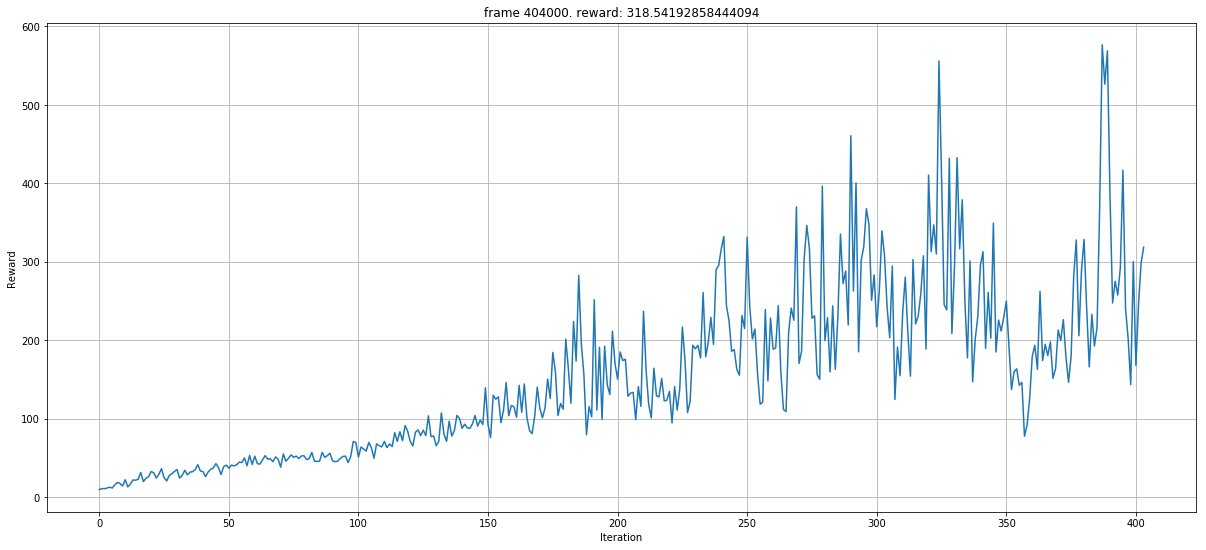

KeyboardInterrupt: ignored

In [15]:
# PPO Hyper-parameters
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = 1000
save_frequency = 10000

ppo = PPO(device, model, optimizer, envs, num_steps, mini_batch_size, ppo_epochs, threshold_reward, save_frequency, savefig=True, save_dir=PATH)

test_rewards = ppo.iterate(test_rewards, max_frames=500000, frame_idx=325001)